# <font color='blue'><ins>TASK</ins></font>
- Given the synthetic dataset generated with the snippet below, carry out the following analyses:
    - **Outlier detection with DBSCAN**. 
        - Try to use DBSCAN algorithm with different parameter configurations. How does it model your distribution of objects?
        - How can you estimate a reasonable value of `eps` parameter?
    - **Outlier detection with LOF**. 
        - Try to use LOF (Local Outlier Factor) to assess if an object is an outlier. 
    - Report and discuss the results in both cases.


In [11]:
import pandas as pd
import numpy as np
np.random.seed(10)
from sklearn.metrics import classification_report as clfrep
from matplotlib import pyplot as plt

Create five blobs: notice that one is "less dense" than others, due to higher value of imposed standard deviation. 

(-10.0, 10.0)

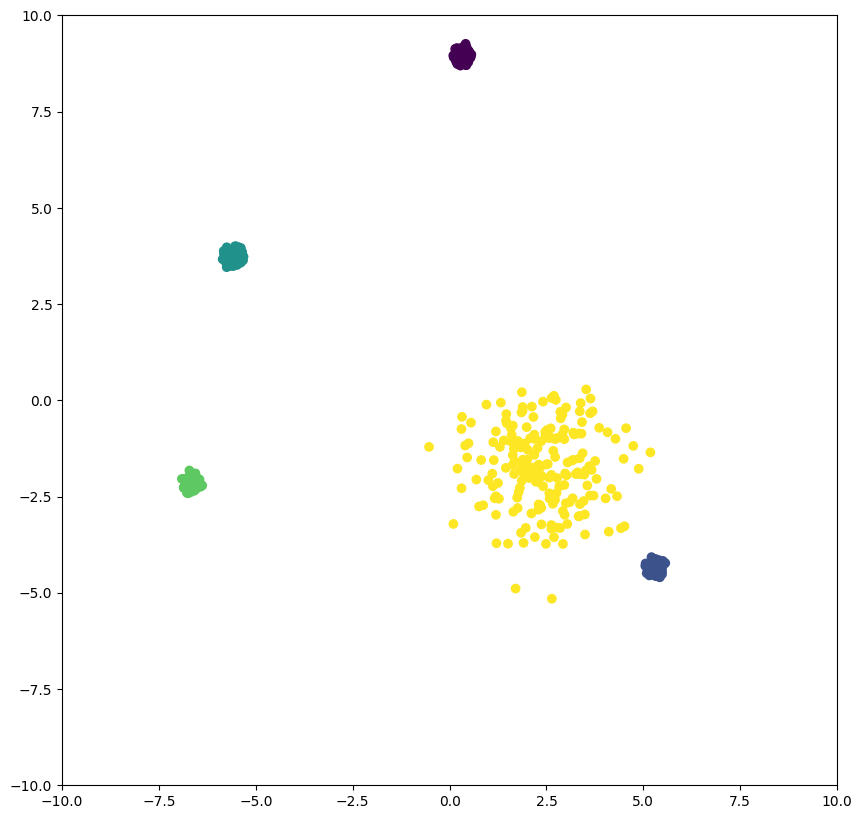

In [12]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=1000, 
                  centers=5,
                  cluster_std = [0.1,0.1,0.1,0.1,1], 
                  center_box = [-10,10], 
                  n_features=2, 
                  random_state=23)
plt.figure(figsize=(10,10))
plt.scatter([x[0] for x in X],[x[1] for x in X],c = y)
plt.xlim([-10,10])
plt.ylim([-10,10])

Add outliers to the dataset: outliers are modelled as 20 instances sampled uniformly in the bidimensional space. 

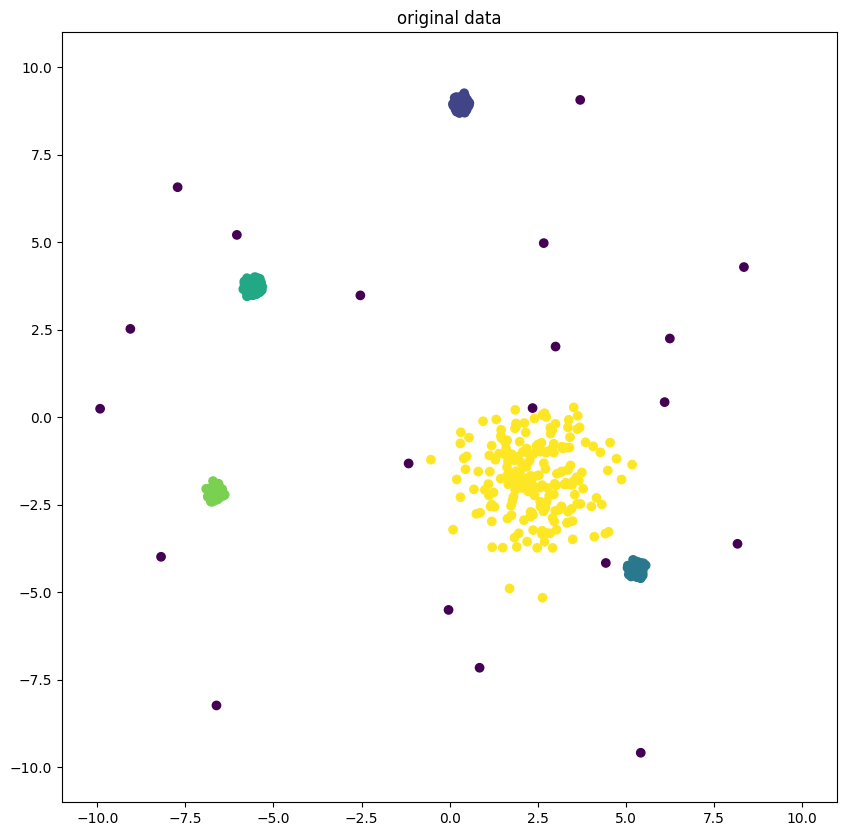

In [13]:
outliers = np.random.uniform(-10,10,(20,2))
data = np.concatenate((X,outliers))
target = np.concatenate((y,np.asarray([-1 for x in range(len(outliers))])))
target_anomaly = np.minimum(target,0)*(-1)
plt.figure(figsize=(10,10))
plt.scatter(data[:,0],data[:,1],c = target)
plt.xlim([-11,11])
plt.ylim([-11,11])
plt.title('original data')
plt.show()

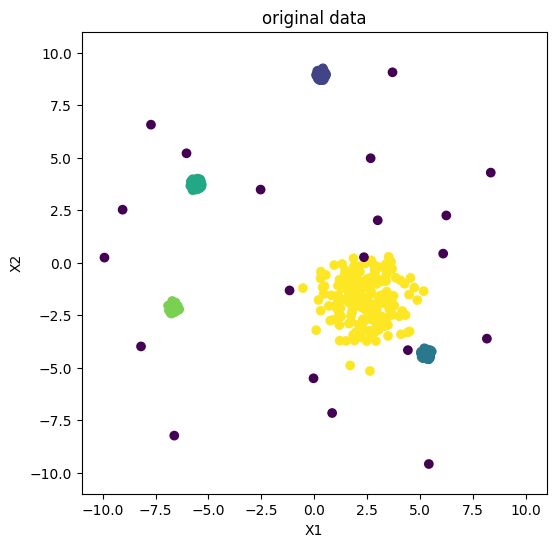

In [14]:
def plot_data(y,title):
    plt.figure(figsize = (6,6))
    plt.scatter(data[:,0],data[:,1], c = y)
    plt.title(title)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.xlim([-11,11])
    plt.ylim([-11,11])
    plt.show()
plot_data(target,'original data')

## Outlier detection based on DBSCAN

DBSCAN clustering mainly depends on the combination of two parameters: $\varepsilon$ and $MinPts$. In the following we fix $MinPts$ e vary $\varepsilon$ in a reasonable range.
To monitor the capability of recognizing outlier, for each clustering evaluation we report:
- the 2D plot with cluster/outlier assignment
- the "classification" report for the assessment of the capability of discriminating outlier/inlier with respect to the ground truth. Notice that, differently from classification task, the ground truth is (typically) unavailable.


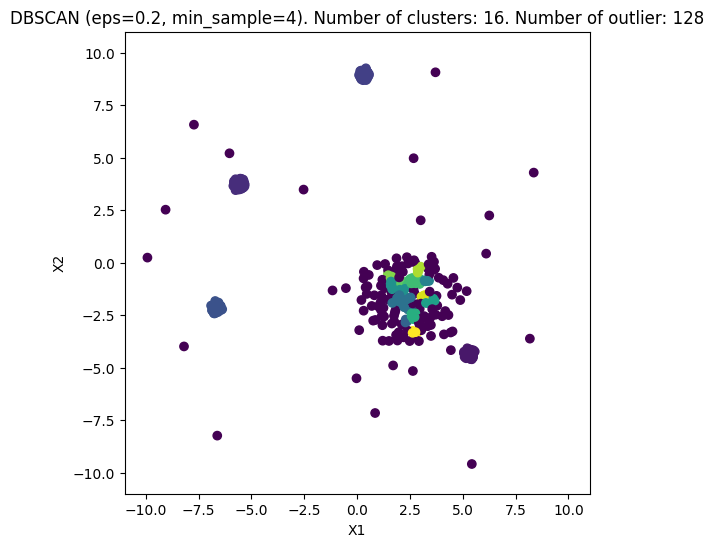

              precision    recall  f1-score   support

      normal       1.00      0.89      0.94      1000
     outlier       0.16      1.00      0.27        20

    accuracy                           0.89      1020
   macro avg       0.58      0.95      0.61      1020
weighted avg       0.98      0.89      0.93      1020



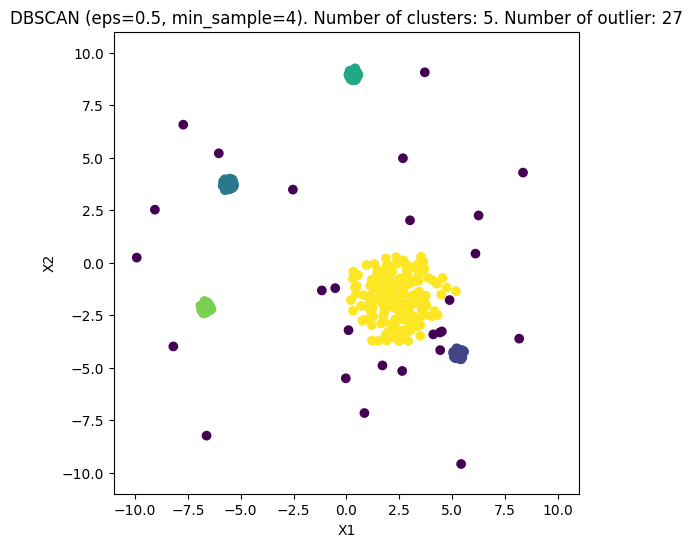

              precision    recall  f1-score   support

      normal       1.00      0.99      1.00      1000
     outlier       0.70      0.95      0.81        20

    accuracy                           0.99      1020
   macro avg       0.85      0.97      0.90      1020
weighted avg       0.99      0.99      0.99      1020



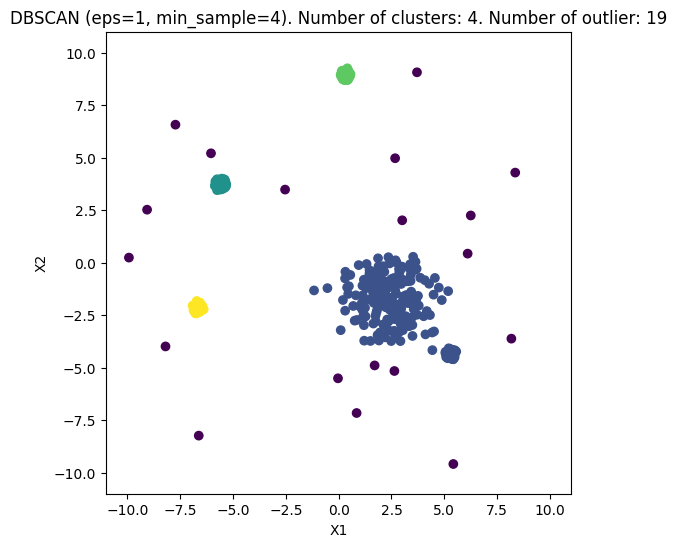

              precision    recall  f1-score   support

      normal       1.00      1.00      1.00      1000
     outlier       0.89      0.85      0.87        20

    accuracy                           1.00      1020
   macro avg       0.95      0.92      0.93      1020
weighted avg       0.99      1.00      1.00      1020



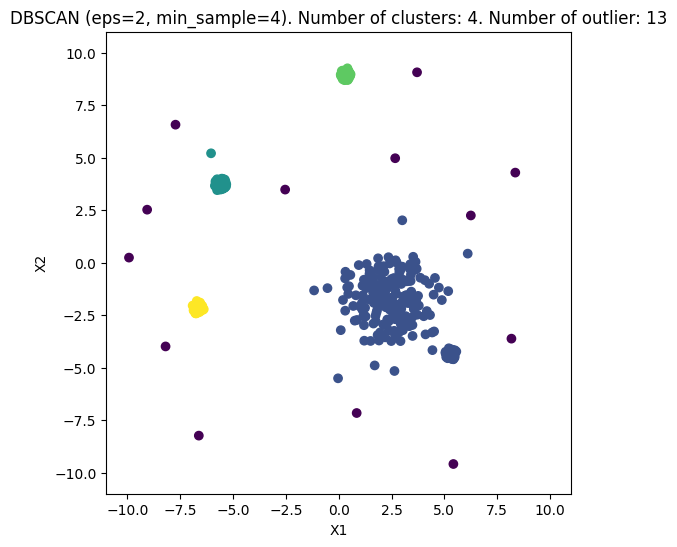

              precision    recall  f1-score   support

      normal       0.99      1.00      1.00      1000
     outlier       1.00      0.65      0.79        20

    accuracy                           0.99      1020
   macro avg       1.00      0.82      0.89      1020
weighted avg       0.99      0.99      0.99      1020



In [15]:
from sklearn.cluster import DBSCAN
min_samples = 4
for eps in [0.2,0.5,1,2]:
    dbscan = DBSCAN(min_samples = min_samples, eps = eps)
    y_assignment = dbscan.fit_predict(data)
    # DBSCAN: Noisy samples are given the label -1.
    n_cluster = len(np.unique([x for x in y_assignment if x>=0]))
    n_outlier = list(y_assignment).count(-1)
    plot_data(y_assignment,f'DBSCAN (eps={eps}, min_sample={min_samples}). Number of clusters: {n_cluster}. Number of outliers: {n_outlier}')
    y_assignment_eval = np.minimum(y_assignment,0)*(-1)
    print(clfrep(target_anomaly,y_assignment_eval,target_names = ['normal','outlier']))
    

Note that
- with low value of $\varepsilon$ ($\varepsilon=0.2$), DBSCAN fails to model the "most sparse" (biggest) blob: many of its objects are improperly marked as outliers. The recall is high (since all actual outliers are recognized as such) but the precision is very low (0.16).
- increasing the value of $\varepsilon$ (larger neighborhood)
    - precision increases: the number of false positive decreases
    - recall decreases: outliers are incorporated in cluster borders.
    
 

The $k$-dist plot can be used for estimating a reasonable value of $\varepsilon$ parameter.


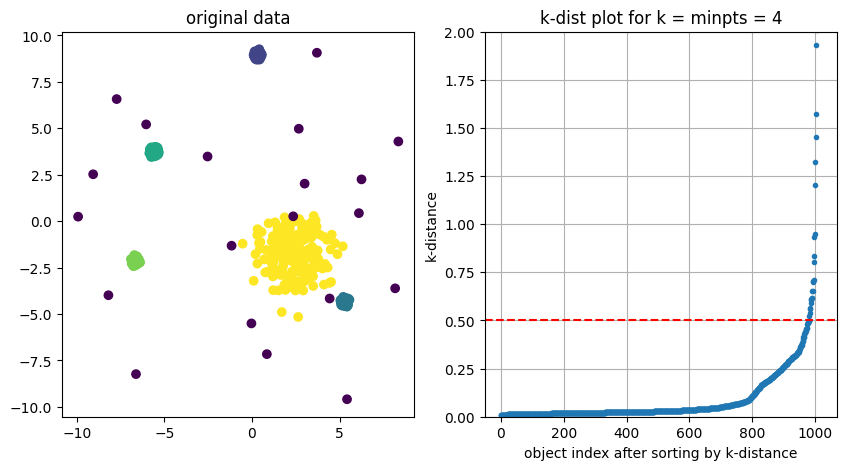

In [16]:
from sklearn.neighbors import NearestNeighbors

minpts = 4
nbrs = NearestNeighbors(n_neighbors=minpts).fit(data) 
distances, indices = nbrs.kneighbors(data)
k_dist = [x[-1] for x in distances]


f,ax = plt.subplots(1,2,figsize = (10,5))
ax[0].set_title('original data')
ax[0].scatter(data[:,0],data[:,1],c = target)
ax[1].set_title('k-dist plot for k = minpts = 4') 
ax[1].plot(sorted(k_dist),'.')
ax[1].set_xlabel('object index after sorting by k-distance')
ax[1].set_ylabel('k-distance')
ax[1].set_ylim([0,2])
ax[1].axhline(0.5,color = 'r',linestyle = '--')
ax[1].grid()

Objects in the right side of the graph are those that are at a higher distance from their $k$-th nearest neighbor. The "elbow" of the plot can be used for setting the value of $\varepsilon$. However, the identification of such an elbow is not always trivial: in our dataset, for example, there is a sharp decrease around index 1000 and a sort of a smaller step around index 800. Objects in between are likely those pertaining to the big, sparse, blob. 

## Outlier detection based on LOF

In [21]:
from sklearn.neighbors import LocalOutlierFactor as LOF

In [23]:
LOF?

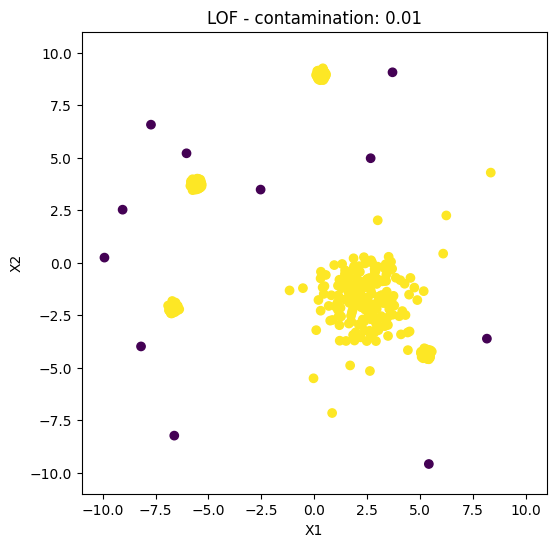

              precision    recall  f1-score   support

      normal       0.99      1.00      1.00      1000
     outlier       1.00      0.55      0.71        20

    accuracy                           0.99      1020
   macro avg       1.00      0.78      0.85      1020
weighted avg       0.99      0.99      0.99      1020



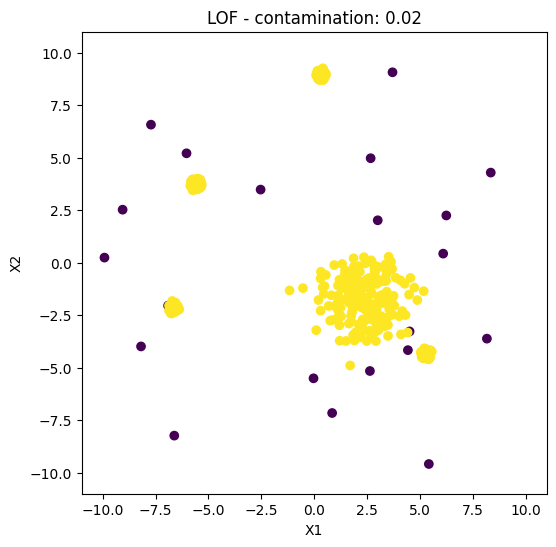

              precision    recall  f1-score   support

      normal       1.00      1.00      1.00      1000
     outlier       0.86      0.90      0.88        20

    accuracy                           1.00      1020
   macro avg       0.93      0.95      0.94      1020
weighted avg       1.00      1.00      1.00      1020



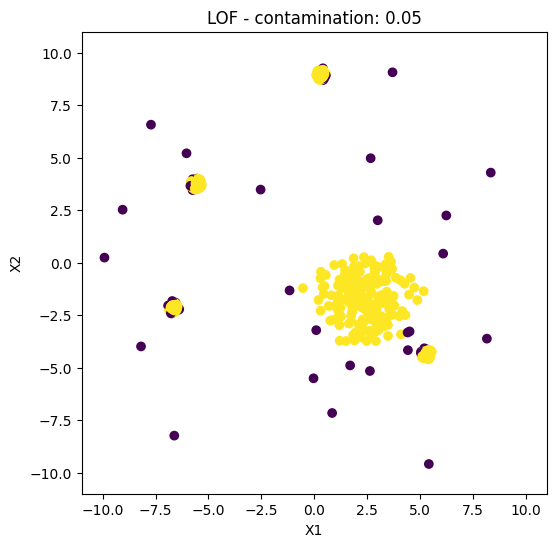

              precision    recall  f1-score   support

      normal       1.00      0.97      0.98      1000
     outlier       0.37      0.95      0.54        20

    accuracy                           0.97      1020
   macro avg       0.69      0.96      0.76      1020
weighted avg       0.99      0.97      0.97      1020



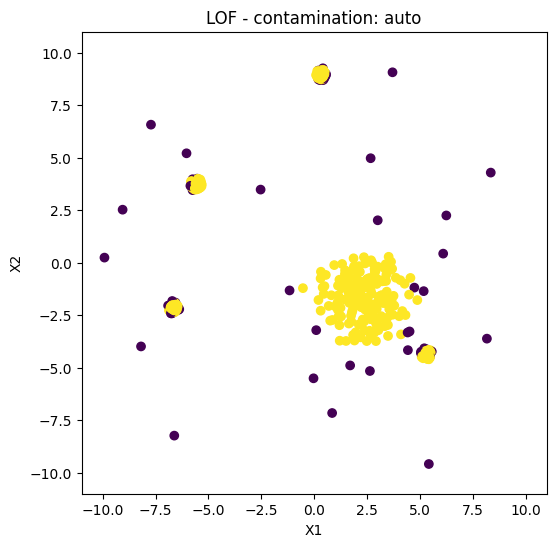

              precision    recall  f1-score   support

      normal       1.00      0.95      0.98      1000
     outlier       0.29      0.95      0.45        20

    accuracy                           0.95      1020
   macro avg       0.65      0.95      0.71      1020
weighted avg       0.99      0.95      0.97      1020



In [24]:
for contamination in [0.01,0.02,0.05, 'auto']: # we have 20 outliers and 1000 inliers
    lof = LOF(n_neighbors = 10,contamination = contamination)
    y_lof = lof.fit_predict(data)
    plot_data(y_lof,f'LOF - contamination: {contamination}')
    y_lof_eval = np.minimum(y_lof,0)*(-1)
    print(clfrep(target_anomaly,y_lof_eval,target_names = ['normal','outlier']))


Notice that our true outlier/inlier ratio is around 0.02 (20/1020). When the contamination is set to such a value we obtain a reasonable modelling of our dataset.

A deeper look in LOF source code: what is the "contamination" parameter.

**Step 1**: set the offset
```python
if self.contamination == "auto":
    self.offset_ = -1.5
else:
    self.offset_ = np.percentile(
        self.negative_outlier_factor_, 100.0 * self.contamination
    )
```

- The offset is set to -1.5 (inliers score around -1), except when a `contamination` parameter different than "auto" is provided. In that case, the offset is defined in such a way we obtain the expected number of outliers in our dataset.


**Step 2**: boolean value: check if the score is higher than the offset.


```python
def decision_function(self):
    return self.score_samples(X) - self.offset_
```

- `score_samples(X)` returns the opposite of the Local Outlier Factor of X.


**Step 3**: `decision_function(X)` lower than the offset --> outlier
```python
if X is not None:
    X = check_array(X, accept_sparse="csr")
    is_inlier = np.ones(X.shape[0], dtype=int)
    is_inlier[self.decision_function(X) < 0] = -1
```

- Objects having a `negative_outlier_factor` (opposite LOF) smaller than `offset_` are detected as abnormal. 

Plot the (negative) local outlier factor for each object in our dataset.

Text(0.5, 0, 'Object index')

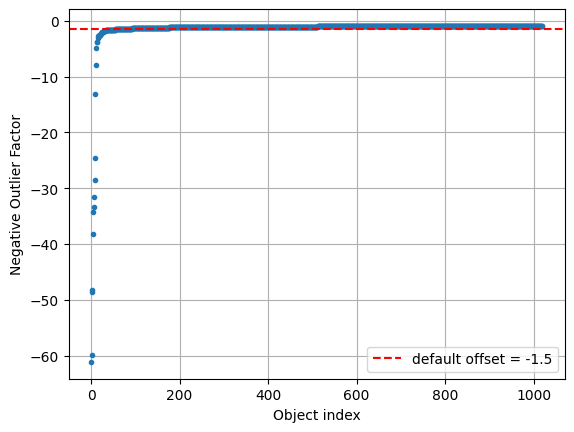

In [10]:
plt.plot(sorted(lof.negative_outlier_factor_),'.')
plt.axhline(-1.5,color = 'red',linestyle = '--', label = 'default offset = -1.5')
plt.grid()
plt.legend()
plt.ylabel('Negative Outlier Factor')
plt.xlabel('Object index')


Zoom on the first 100 objects.

(0.0, 100.0)

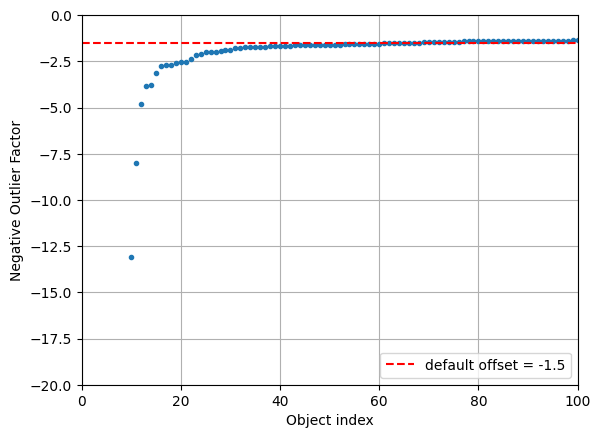

In [11]:
plt.plot(sorted(lof.negative_outlier_factor_),'.')
plt.axhline(-1.5,color = 'red',linestyle = '--', label = 'default offset = -1.5')
plt.grid()
plt.legend()
plt.ylabel('Negative Outlier Factor')
plt.xlabel('Object index')
plt.ylim([-20,0])
plt.xlim([0,100])